# SKIN CANCER DETECTION

In [2]:
# Core libraries
import pandas as pd  
import numpy as np   
import os
import shutil
import json

%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Visualization (optional but useful for EDA)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Preprocessing tools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import  Input , Conv2D, MaxPooling2D, Flatten, Dense , Dropout, BatchNormalization , concatenate, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import itertools
from tensorflow.keras import layers, optimizers



2025-07-29 14:41:36.031937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753800096.235506      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753800096.292678      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Data Preparation

In [3]:
# pathes to files
metadata_csv = '/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv'
image_dir = '/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer'
output_dir = '/kaggle/working/skin_cancer_split'

In [4]:
# definition of data frame
df = pd.read_csv('/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv')

# Display the first few rows of the DataFrame
print("Shape of the DataFrame:", df.shape)
print(df.head())
print("Columns in the DataFrame:", df.columns)
print("Basic statistics of the DataFrame:")
print("\nSummary statistics:\n", df.describe())
print("\nData types:\n", df.dtypes)

Shape of the DataFrame: (10015, 7)
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Columns in the DataFrame: Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')
Basic statistics of the DataFrame:

Summary statistics:
                age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000

Data types:
 lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object


In [5]:
# Check for missing values
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [6]:
# fill missing values
df['age'] = df['age'].fillna(df['age'].median())

In [7]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


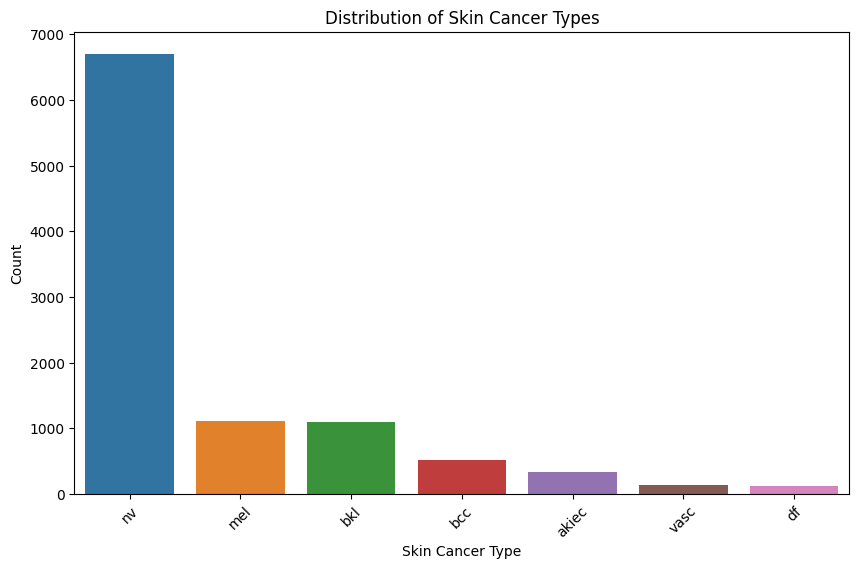

In [8]:
# distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dx', order=df['dx'].value_counts().index)
plt.title('Distribution of Skin Cancer Types')
plt.xlabel('Skin Cancer Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [9]:
# check dataframe
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [10]:
# extend columns of df by image_path
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

# Filter out missing files (in case)
df = df[df['image_path'].apply(os.path.exists)]

In [11]:
# check dataframe
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                          image_path  
0  /kaggle/input/skin-cancer-dataset/Skin Cancer/...  
1  /kaggle/input/skin-cancer-dataset/Skin Cancer/...  
2  /kaggle/input/skin-cancer-dataset/Skin Cancer/...  
3  /kaggle/input/skin-cancer-dataset/Skin Cancer/...  
4  /kaggle/input/skin-cancer-dataset/Skin Cancer/...  


In [12]:
# split dataset into train 70%, val 15% and test 15%
df_train, df_temp = train_test_split(df, test_size=0.30, stratify=df['dx'], random_state=42)

df_val, df_test = train_test_split(df_temp, test_size=0.50, stratify=df_temp['dx'], random_state=42)

# Check splits
print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")


Train: 7010, Val: 1502, Test: 1503


In [13]:
# Copy files to folders
def copy_images(df_subset, subset_name):
    for _, row in df_subset.iterrows():
        class_name = row['dx']
        src_path = row['image_path']
        dst_dir = os.path.join(output_dir, subset_name, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, os.path.basename(src_path))
        shutil.copy(src_path, dst_path)

copy_images(df_train, 'train')
copy_images(df_val, 'val')
copy_images(df_test, 'test')

In [14]:
# data pipeline
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/skin_cancer_split/train',
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/skin_cancer_split/val',
    image_size=(224, 224),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/skin_cancer_split/test',
    image_size=(224, 224),
    batch_size=32
)


Found 7010 files belonging to 7 classes.


I0000 00:00:1753800246.726036      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1502 files belonging to 7 classes.
Found 1503 files belonging to 7 classes.


## 2. Visualize some samples

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


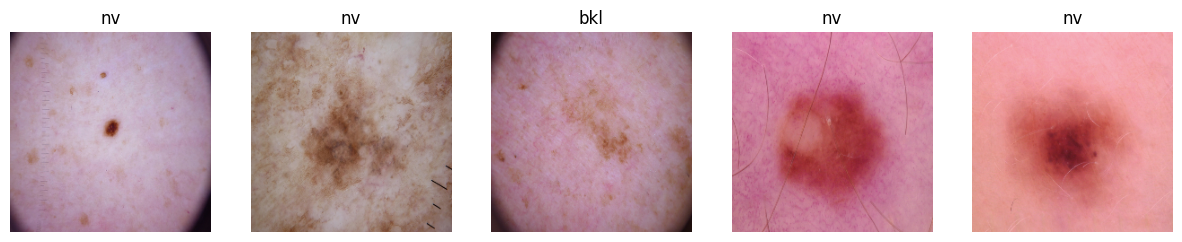

In [15]:
# View class names
class_names = train_ds.class_names
print("Classes:", class_names)

# Visualize
for images, labels in train_ds.take(1):
    plt.figure(figsize=(15, 5))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()


## 3. Baseline Model 

### 3.1 Definition

In [16]:
# Get number of classes from dataset
num_classes = len(train_ds.class_names)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)), 

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()
print(len(model.layers))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

11


### 3.2 Baseline Model Run

In [17]:
# run the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10 
)

Epoch 1/10


I0000 00:00:1753800488.597289      83 service.cc:148] XLA service 0x7a2c3c006090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753800488.599055      83 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753800489.036174      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/220 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.4770 - loss: 3.5465

I0000 00:00:1753800493.417342      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


220/220 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.6495 - loss: 1.2879 - val_accuracy: 0.6724 - val_loss: 0.8887
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.6808 - loss: 0.9054 - val_accuracy: 0.6738 - val_loss: 1.0384
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.6917 - loss: 0.8345 - val_accuracy: 0.6991 - val_loss: 0.8267
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.7044 - loss: 0.7873 - val_accuracy: 0.7011 - val_loss: 0.8301
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.7123 - loss: 0.7575 - val_accuracy: 0.7230 - val_loss: 0.7804
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.7175 - loss: 0.7464 - val_accuracy: 0.7124 - val_loss: 0.8350
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.7466 - loss: 0.6774 - val_accuracy: 0.7237 - val_loss: 0.8485
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.7644 - loss: 0.6387 - val_accura

### 3.3 Baseline Model Results, Evaluation and Plots

In [18]:
# print results
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.6796 - loss: 0.9279
Test Accuracy: 0.6986


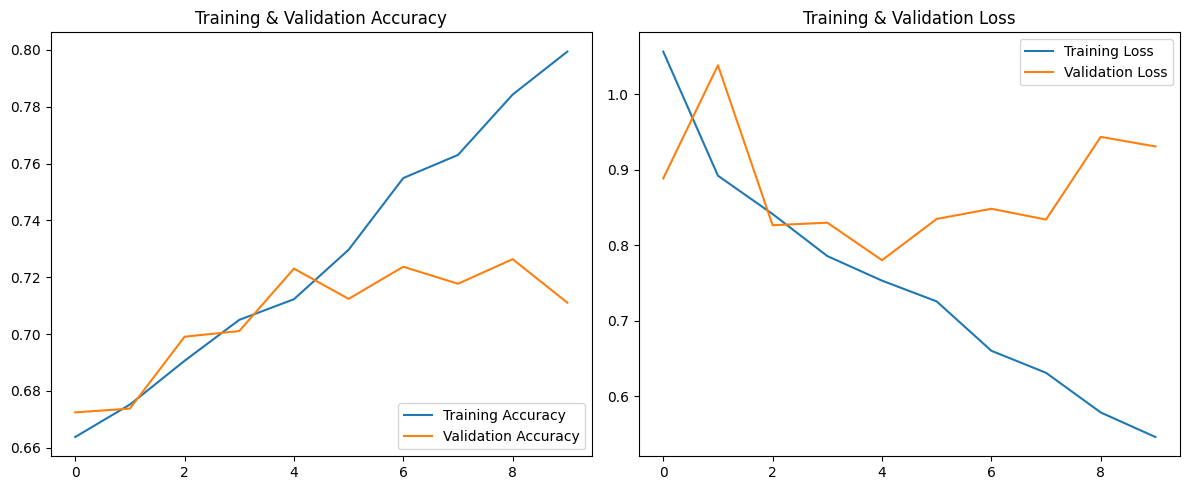

In [19]:
# plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [20]:
# Overall F1 scores
# Get class names from dataset for classification report print
class_names = test_ds.class_names

# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(" F1 Scores:")
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

# Full classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

 F1 Scores:
Macro F1: 0.35875536352016224
Micro F1: 0.6986027944111777
Weighted F1: 0.6719918729367705

 Classification Report:
              precision    recall  f1-score   support

       akiec       0.38      0.10      0.16        49
         bcc       0.41      0.22      0.29        77
         bkl       0.39      0.34      0.36       165
          df       0.00      0.00      0.00        17
         mel       0.41      0.38      0.39       167
          nv       0.79      0.90      0.84      1006
        vasc       0.88      0.32      0.47        22

    accuracy                           0.70      1503
   macro avg       0.47      0.32      0.36      1503
weighted avg       0.66      0.70      0.67      1503



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


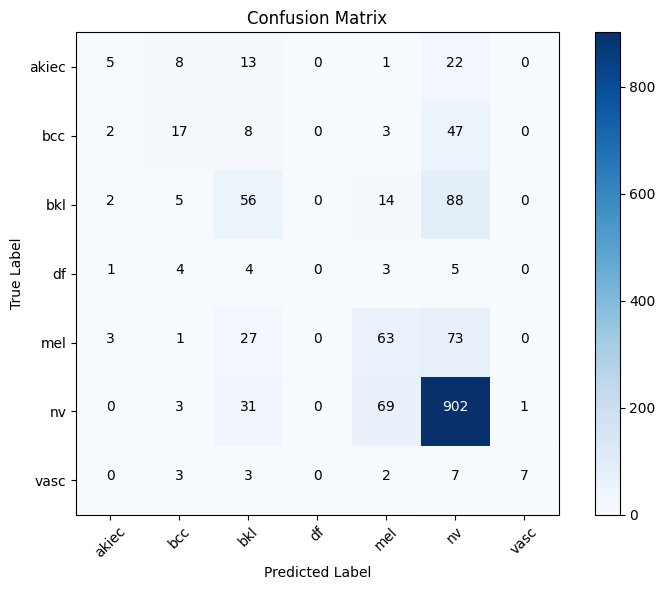

In [21]:
# plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

## 4. Model Definition

### 4.1 Data augmentation and class weights

In [23]:
# image augmentation function
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

In [24]:
# adding augmentation to the model
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax')  
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 4.2 Weights

In [25]:
# Get true labels from train_ds for weight calculation
y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(labels.numpy())
y_train = np.array(y_train)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# convert weights for model use
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 4.37305053025577, 1: 2.7817460317460316, 2: 1.3022478172023035, 3: 12.36331569664903, 4: 1.285530900421786, 5: 0.21338772031292808, 6: 10.115440115440116}


### 4.3 Model Run

In [26]:
# model with class weights
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.3819 - loss: 1.9747 - val_accuracy: 0.3622 - val_loss: 1.7059
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.4016 - loss: 1.7046 - val_accuracy: 0.2617 - val_loss: 1.5585
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.3462 - loss: 1.5914 - val_accuracy: 0.1558 - val_loss: 2.0721
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.3340 - loss: 1.6288 - val_accuracy: 0.1951 - val_loss: 1.9106
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.3984 - loss: 1.5021 - val_accuracy: 0.3142 - val_loss: 1.5128
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.3887 - loss: 1.5117 - val_accuracy: 0.4807 - val_loss: 1.4087
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.4952 - loss: 1.3715 - val_accuracy: 0.3822 - val_loss: 1.4101
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.4158 - loss: 1.3795 - 

### 4.4 Model Results

In [27]:
# print results
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5136 - loss: 1.1542
Test Accuracy: 0.5050


In [28]:
# Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_names = test_ds.class_names

print("🔍 F1 Scores:")
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

🔍 F1 Scores:
Macro F1: 0.3367974282630076
Micro F1: 0.5049900199600799
Weighted F1: 0.5544408962392998

📄 Classification Report:
              precision    recall  f1-score   support

       akiec       0.17      0.37      0.24        49
         bcc       0.35      0.35      0.35        77
         bkl       0.38      0.22      0.28       165
          df       0.00      0.00      0.00        17
         mel       0.22      0.79      0.35       167
          nv       0.95      0.52      0.68      1006
        vasc       0.33      0.77      0.47        22

    accuracy                           0.50      1503
   macro avg       0.34      0.43      0.34      1503
weighted avg       0.73      0.50      0.55      1503



## 5. Transfer Learning MobileNetV2

### 5.1 Model definition

In [22]:
# Load MobileNetV2 base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the convolutional base

# Define input layer
inputs = layers.Input(shape=(224, 224, 3))

# data prep
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    
    # Data augmentation (optional)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.2)
    
    img = preprocess_input(img)  # MobileNetV2 preprocessing
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((image_paths_train, labels_train))
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((image_paths_val, labels_val))
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Data augmentation (applied to raw images)
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

# Preprocessing for MobileNetV2 (expects input in [0, 255])
x = preprocess_input(x)

# Pass through base model
x = base_model(x, training=False)

# Custom classification head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(7, activation='softmax')(x)

# Create model
model = models.Model(inputs, outputs)

# compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


NameError: name 'image_paths_train' is not defined

### 5.2 Model MobileNetV2 run

In [ ]:
# run model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

### 5.3 MobileNetV2 Fine-tuning

In [ ]:
# print # of layers for unfreezing
print('Number of layers:', len(model.layers))

# Load base model without top layers
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze top layers for fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Freeze the bottom layers, fine-tune the top
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
# Input layer
inputs = tf.keras.Input(shape=(224, 224, 3))

# Data augmentation
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)
x = layers.RandomContrast(0.1)(x)

# Preprocess for MobileNetV2
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# Pass through base model
x = base_model(x, training=False)

# Custom classification head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(7, activation='softmax')(x)

# Assemble model
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # low LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

### 5.4 Model MobileNetV2 run

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

### 5.5 MobileNetV2 Results, Evaluation and Plots

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Collect predictions and labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_names = test_ds.class_names

In [ ]:
print(" F1 Scores:")
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

In [ ]:


def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

### 5.6 MobileNetV2 further fine-tuning: Focal loss with Class weight

In [ ]:
def focal_loss_with_class_weights(class_weights, gamma=2.):
    class_weights = tf.constant(class_weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=y_pred.shape[-1])
        
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true_one_hot, y_pred)
        probs = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)
        class_alphas = tf.gather(class_weights, y_true)
        focal_weight = tf.pow(1. - probs, gamma)
        
        loss = class_alphas * focal_weight * cross_entropy
        return loss
    
    return loss

In [ ]:
# Collect labels from train_ds
y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(labels.numpy())
y_train = np.array(y_train)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

In [ ]:
# Convert class_weights dict to ordered list
class_weights_list = [class_weights[i] for i in range(len(class_weights))]


focal = focal_loss_with_class_weights(class_weights_list, gamma=2.0)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=focal,
    metrics=['accuracy']
)

### 5.7 MobileNetV2 fine-tuned run

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

### 5.8 MobileNetV2 Results, Evaluation and Plots

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Collect predictions and labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_names = test_ds.class_names

In [ ]:
print(" F1 Scores:")
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

In [ ]:
model.save("baseline_mobilenetv2_focal.keras")

### 5.9 MobileNetV2 further fine-tuning

In [ ]:
model = tf.keras.models.load_model("baseline_mobilenetv2_focal.keras", compile=False)

In [ ]:
# Get the MobileNetV2 base model
base_model = model.layers[5]  

# Unfreeze deeper layers starting at layer 75
fine_tune_at = 75
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True




In [ ]:
focal = focal_loss_with_class_weights(class_weights_list, gamma=1.5)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss=focal,
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("finetuned_model.keras", save_best_only=True)
]

### 5.10 MobileNetV2 further fine-tune run

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    initial_epoch=10,  
    callbacks=callbacks
)

### 5.11 MobileNetV2 Results, Evaluation and Plots

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


In [ ]:
# Collect predictions and labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_names = test_ds.class_names

In [ ]:
print(" F1 Scores:")
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

## 6. Transfer Learning EfficientNetB0

### 6.1 Model Definition

In [ ]:
# Load pre-trained base (exclude top)
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

In [ ]:
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss=focal_loss_with_class_weights(class_weights_list, gamma=1.5),
    metrics=['accuracy']
)

### 6.2 EfficientNetB0 Model Run

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

### 6.3 EfficientNetB0 Results, Evaluation and Plots

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


In [ ]:
# Collect predictions and labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_names = test_ds.class_names

In [ ]:
print(" F1 Scores:")
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

### 6.4 Fine tuning the EfficientNetB0 model

In [ ]:
# Unfreeze top layers
base_model.trainable = True

# freeze some layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss=focal_loss_with_class_weights(class_weights_list, gamma=1.5),
    metrics=['accuracy']
)



### 6.5 EfficientNetB0 fine-tune run

In [ ]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    initial_epoch=10,
    callbacks=callbacks
)

### 6. EfficientNetB0 fine-tune Results, Evaluation and Plots

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# Collect predictions and labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_names = test_ds.class_names

In [ ]:
print(" F1 Scores:")
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

## 7. Proceeding to EfficientNetB1

### 7.1 EfficientNetB1 Model Definition and tuning

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras import layers, models, optimizers, callbacks

In [ ]:
# Load EfficientNetB1 base (exclude top classifier)
base_model = EfficientNetB1(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # freeze initially

In [ ]:
# Define full model
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

In [ ]:
# Compile with focal loss + class weights (already converted to list)
focal = focal_loss_with_class_weights(class_weights_list, gamma=1.5)
model.compile(optimizer=optimizers.Adam(1e-4), loss=focal, metrics=['accuracy'])

### 7.2 EfficientNetB1 Model run

In [ ]:
# Initial training
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=10, 
    callbacks=[early_stop]
)

### 7.3 EfficientNetB1 Model further fine-tuning

In [ ]:

fine_tune_at = 100
base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model.compile(optimizer=optimizers.Adam(1e-5), loss=focal, metrics=['accuracy'])

### 7.4 EfficientNetB1 Model further fine-tuning run

In [ ]:
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    initial_epoch=10,
    callbacks=[early_stop]
)

### 7.5 EfficientNetB1 Model fine-tune Results, Evaluation and Plots

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

#Adjusting LR and gamma
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss_with_class_weights(class_weights_list, gamma=1.25),
    metrics=['accuracy']
)


### 7.6 EfficientNetB1 Model further fine-tune run

In [ ]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=30,
    epochs= 70,  
    callbacks=[early_stop] 
)

### 7.7 EfficientNetB1 Model further fine-tune Results, Evaluation and Plots

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# Combine training history
acc = fine_tune_history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = fine_tune_history.history['val_accuracy'] + history_finetune.history['val_accuracy']

loss = fine_tune_history.history['loss'] + history_finetune.history['loss']
val_loss = fine_tune_history.history['val_loss'] + history_finetune.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plotting
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_names = test_ds.class_names

# Metrics
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Micro F1:", f1_score(y_true, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

In [ ]:
model.save("efficientnetb1_finetuned_best.keras")

### 7.8 EfficientNetB1 Applying Test-Time Augmentation (TTA)

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('efficientnetb1_finetuned_best.keras', compile=False)

# Define a set of augmentations to apply at test time
tta_transforms = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    #tf.keras.layers.Rescaling(1./255) 
])

In [ ]:
# Number of augmentations per image
TTA_STEPS = 5

# Run predictions with TTA
def predict_with_tta(model, dataset, tta_steps=TTA_STEPS):
    predictions = []

    for _ in range(tta_steps):
        augmented_ds = dataset.map(lambda x, y: (tta_transforms(x, training=True), y),
                                   num_parallel_calls=tf.data.AUTOTUNE)
        preds = model.predict(augmented_ds, verbose=0)
        predictions.append(preds)

    return np.mean(predictions, axis=0)

### 7.9 EfficientNetB1 Predictions and Plots

In [ ]:
# Run TTA predictions
tta_preds = predict_with_tta(model, test_ds)

# Convert predictions to final labels
final_preds = np.argmax(tta_preds, axis=1)

# Get true labels
true_labels = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Class names 
class_names = test_ds.class_names

tta_preds = predict_with_tta(model, test_ds, tta_steps=5)
tta_labels = np.argmax(tta_preds, axis=1)  

# Print classification report
print("TTA Classification Report:")
print(classification_report(y_true, tta_labels, target_names=class_names))

# F1 Scores
print("Macro F1:", f1_score(y_true, tta_labels, average='macro'))
print("Micro F1:", f1_score(y_true, tta_labels, average='micro'))
print("Weighted F1:", f1_score(y_true, tta_labels, average='weighted'))

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true, tta_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with TTA")
plt.tight_layout()
plt.show()

## 8. Final Ensemble Code (MobileNetV2 + EfficientNetB1)

### 8.1 Model Definition

In [ ]:
def focal_loss_with_class_weights(class_weights, gamma=2.0):
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_onehot = tf.one_hot(y_true, depth=len(class_weights))
        cross_entropy = -y_true_onehot * tf.math.log(tf.clip_by_value(y_pred, 1e-7, 1.0))
        weights = tf.gather(class_weights, y_true)
        focal = weights * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(focal, axis=-1))
    
    return loss

In [ ]:
custom_loss = focal_loss_with_class_weights(class_weights_list, gamma=1.5)

# Load both models using the same custom_objects argument
mobilenet_model = tf.keras.models.load_model(
    "baseline_mobilenetv2_focal.keras",
    custom_objects={"loss": custom_loss}
)

efficientnet_model = tf.keras.models.load_model(
    "efficientnetb1_finetuned_best.keras",
    custom_objects={"loss": custom_loss}
)


In [ ]:
# Get softmax predictions from both models
y_true = []
ensemble_preds = []

for images, labels in test_ds:
    mobilenet_probs = mobilenet_model.predict(images, verbose=0)
    efficientnet_probs = efficientnet_model.predict(images, verbose=0)

    avg_probs = (mobilenet_probs + efficientnet_probs) / 2.0
    preds = np.argmax(avg_probs, axis=1)

    ensemble_preds.extend(preds)
    y_true.extend(labels.numpy())  

ensemble_preds = np.array(ensemble_preds)
y_true = np.array(y_true)


### 8.2 Ensemble Classification, Reports and Plots

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

In [ ]:
class_names = test_ds.class_names

print("Ensemble Classification Report:")
print(classification_report(y_true, ensemble_preds, target_names=class_names))

# F1 scores
print("Macro F1:", f1_score(y_true, ensemble_preds, average='macro'))
print("Micro F1:", f1_score(y_true, ensemble_preds, average='micro'))
print("Weighted F1:", f1_score(y_true, ensemble_preds, average='weighted'))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, ensemble_preds)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — Ensemble (MobileNetV2 + EfficientNetB1)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Define class names (from your dataset)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Step 2: Load both models
mobilenet_model = tf.keras.models.load_model("baseline_mobilenetv2_focal.keras", compile=False)
efficientnet_model = tf.keras.models.load_model("efficientnetb1_finetuned_best.keras", compile=False)

# Step 3: Run predictions
y_true = []
mobilenet_preds = []
efficientnet_preds = []
ensemble_preds = []

for images, labels in test_ds:
    labels_np = labels.numpy()
    y_true.extend(labels_np)

    mobilenet_probs = mobilenet_model.predict(images, verbose=0)
    efficientnet_probs = efficientnet_model.predict(images, verbose=0)

    mobilenet_pred = np.argmax(mobilenet_probs, axis=1)
    efficientnet_pred = np.argmax(efficientnet_probs, axis=1)

    avg_probs = (mobilenet_probs + efficientnet_probs) / 2.0
    ensemble_pred = np.argmax(avg_probs, axis=1)

    mobilenet_preds.extend(mobilenet_pred)
    efficientnet_preds.extend(efficientnet_pred)
    ensemble_preds.extend(ensemble_pred)

# Convert to arrays
y_true = np.array(y_true)
mobilenet_preds = np.array(mobilenet_preds)
efficientnet_preds = np.array(efficientnet_preds)
ensemble_preds = np.array(ensemble_preds)

# Step 4: Compute F1 scores dynamically
labels = ['MobileNetV2', 'EfficientNetB1', 'Ensemble']
f1_macro = [
    f1_score(y_true, mobilenet_preds, average='macro'),
    f1_score(y_true, efficientnet_preds, average='macro'),
    f1_score(y_true, ensemble_preds, average='macro')
]

f1_micro = [
    f1_score(y_true, mobilenet_preds, average='micro'),
    f1_score(y_true, efficientnet_preds, average='micro'),
    f1_score(y_true, ensemble_preds, average='micro')
]

f1_weighted = [
    f1_score(y_true, mobilenet_preds, average='weighted'),
    f1_score(y_true, efficientnet_preds, average='weighted'),
    f1_score(y_true, ensemble_preds, average='weighted')
]

# Step 5: Plot
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, f1_macro, width, label='Macro F1')
plt.bar(x, f1_micro, width, label='Micro F1')
plt.bar(x + width, f1_weighted, width, label='Weighted F1')

plt.xticks(x, labels)
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.title("Macro, Micro, and Weighted F1 Scores by Model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Compute class-wise F1 scores for each model
mobilenet_f1 = f1_score(y_true, mobilenet_preds, average=None)
efficientnet_f1 = f1_score(y_true, efficientnet_preds, average=None)
ensemble_f1 = f1_score(y_true, ensemble_preds, average=None)

x = np.arange(len(class_names))  # the label locations
width = 0.25  # width of the bars

# Plotting
plt.figure(figsize=(14, 6))
plt.bar(x - width, mobilenet_f1, width, label='MobileNetV2')
plt.bar(x, efficientnet_f1, width, label='EfficientNetB1')
plt.bar(x + width, ensemble_f1, width, label='Ensemble')

plt.ylabel('F1 Score')
plt.xlabel('Classes')
plt.title('Class-wise F1 Scores by Model')
plt.xticks(x, class_names, rotation=45)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
#Define weeights
w_eff = 0.6
w_mob = 0.4

Predict using both models 
ensemble_preds_weighted = []
y_true = []

for images, labels in test_ds:
    mobilenet_probs = mobilenet_model.predict(images, verbose=0)
    efficientnet_probs = efficientnet_model.predict(images, verbose=0)

    combined_probs = w_mob * mobilenet_probs + w_eff * efficientnet_probs
    preds = np.argmax(combined_probs, axis=1)
    
    ensemble_preds_weighted.extend(preds)
    y_true.extend(labels.numpy())  


ensemble_preds_weighted = np.array(ensemble_preds_weighted)
y_true = np.array(y_true)

# Classification Report & F1 Scores
report = classification_report(y_true, ensemble_preds_weighted, output_dict=True)
f1_macro = f1_score(y_true, ensemble_preds_weighted, average='macro')
f1_micro = f1_score(y_true, ensemble_preds_weighted, average='micro')
f1_weighted = f1_score(y_true, ensemble_preds_weighted, average='weighted')

print(f"Macro F1: {f1_macro:.4f}")
print(f"Micro F1: {f1_micro:.4f}")
print(f"Weighted F1: {f1_weighted:.4f}")

# Confusion Matrix 
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
cm = confusion_matrix(y_true, ensemble_preds_weighted)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Weighted Ensemble (0.6 EfficientNetB1 + 0.4 MobileNetV2)")
plt.show()

# Per-Class F1 Scores 
# Create classification report using class indices as labels
report = classification_report(y_true, ensemble_preds_weighted, output_dict=True)

# Map index to class name (make sure class_names is defined in correct order)
index_to_class = {i: name for i, name in enumerate(class_names)}

# Extract per-class F1 using index keys ('0', '1', ...) and rename them to class names
f1_per_class = {
    index_to_class[int(cls)]: report[cls]['f1-score']
    for cls in report.keys() if cls.isdigit()
}

# Create DataFrame and plot
f1_class_df = pd.DataFrame.from_dict(f1_per_class, orient='index', columns=['F1 Score'])
f1_class_df = f1_class_df.sort_values(by='F1 Score', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
f1_class_df.plot(kind='bar', legend=False, color='skyblue')
plt.title('Class-wise F1 Scores — Weighted Ensemble')
plt.ylabel('F1 Score')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Initialize lists
mobilenet_preds = []
efficientnet_preds = []
ensemble_preds = []
ensemble_preds_weighted = []
y_true = []

# Step 2: Collect predictions
for images, labels in test_ds:
    m_probs = mobilenet_model.predict(images, verbose=0)
    e_probs = efficientnet_model.predict(images, verbose=0)

    # Individual predictions
    mobilenet_preds.extend(np.argmax(m_probs, axis=1))
    efficientnet_preds.extend(np.argmax(e_probs, axis=1))

    # Simple average ensemble
    avg_probs = (m_probs + e_probs) / 2.0
    ensemble_preds.extend(np.argmax(avg_probs, axis=1))

    # Weighted ensemble (EfficientNetB1: 0.6, MobileNetV2: 0.4)
    weighted_probs = (0.6 * e_probs + 0.4 * m_probs)
    ensemble_preds_weighted.extend(np.argmax(weighted_probs, axis=1))

    # True labels (one-hot to class index)
    y_true.extend(labels.numpy())


# Step 3: Convert to arrays
mobilenet_preds = np.array(mobilenet_preds)
efficientnet_preds = np.array(efficientnet_preds)
ensemble_preds = np.array(ensemble_preds)
ensemble_preds_weighted = np.array(ensemble_preds_weighted)
y_true = np.array(y_true)

# Step 4: Compute F1 Scores
macro_f1 = [
    f1_score(y_true, mobilenet_preds, average='macro'),
    f1_score(y_true, efficientnet_preds, average='macro'),
    f1_score(y_true, ensemble_preds, average='macro'),
    f1_score(y_true, ensemble_preds_weighted, average='macro'),
]

micro_f1 = [
    f1_score(y_true, mobilenet_preds, average='micro'),
    f1_score(y_true, efficientnet_preds, average='micro'),
    f1_score(y_true, ensemble_preds, average='micro'),
    f1_score(y_true, ensemble_preds_weighted, average='micro'),
]

weighted_f1 = [
    f1_score(y_true, mobilenet_preds, average='weighted'),
    f1_score(y_true, efficientnet_preds, average='weighted'),
    f1_score(y_true, ensemble_preds, average='weighted'),
    f1_score(y_true, ensemble_preds_weighted, average='weighted'),
]

print("Macro F1:", macro_f1)
print("Micro F1:", micro_f1)
print("Weighted F1:", weighted_f1)

# Step 5: Plot
labels = ['MobileNetV2', 'EfficientNetB1', 'Ensemble', 'Weighted Ensemble']
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, macro_f1, width=width, label='Macro F1')
plt.bar(x, micro_f1, width=width, label='Micro F1')
plt.bar(x + width, weighted_f1, width=width, label='Weighted F1')

plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Macro, Micro, and Weighted F1 Scores by Model')
plt.xticks(ticks=x, labels=labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Paths to your saved base models
mobilenet_path = "baseline_mobilenetv2_focal.keras"
efficientnet_path = "efficientnetb1_finetuned_best.keras"

# Common metadata
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
input_size = [224, 224]

#  Save Average Ensemble 
avg_dir = "ensemble_avg"
os.makedirs(avg_dir, exist_ok=True)

# Copy base models into this folder
shutil.copy(mobilenet_path, os.path.join(avg_dir, "mobilenet_model.keras"))
shutil.copy(efficientnet_path, os.path.join(avg_dir, "efficientnet_model.keras"))

# Save config
avg_config = {
    "ensemble_type": "average",
    "mobilenet_model_path": "mobilenet_model.keras",
    "efficientnet_model_path": "efficientnet_model.keras",
    "input_size": input_size,
    "class_names": class_names
}

with open(os.path.join(avg_dir, "config.json"), "w") as f:
    json.dump(avg_config, f, indent=4)

print(" Saved average ensemble config to:", avg_dir)


# Save Weighted Ensemble
weighted_dir = "ensemble_weighted"
os.makedirs(weighted_dir, exist_ok=True)

# Copy base models into this folder
shutil.copy(mobilenet_path, os.path.join(weighted_dir, "mobilenet_model.keras"))
shutil.copy(efficientnet_path, os.path.join(weighted_dir, "efficientnet_model.keras"))

# Save config
weighted_config = {
    "ensemble_type": "weighted_average",
    "mobilenet_model_path": "mobilenet_model.keras",
    "efficientnet_model_path": "efficientnet_model.keras",
    "mobilenet_weight": 0.4,
    "efficientnet_weight": 0.6,
    "input_size": input_size,
    "class_names": class_names
}

with open(os.path.join(weighted_dir, "config.json"), "w") as f:
    json.dump(weighted_config, f, indent=4)

print(" Saved weighted ensemble config to:", weighted_dir)

#We can use load_ensemble() functioin to load them later

**Moving on to Grid sarch for for dynamic weights**